In [12]:
import pickle
import numpy as np
from scipy import fftpack, signal, stats

# Load the .pkz file
with open('data/XJTU_bearing_dataset/35Hz12kN/Bearing1_1.pkz', 'rb') as f:
    data = pickle.load(f)

# Now 'data' contains the Python object stored in the .pkz file
signal_data = data[0][:, 0]

In [26]:
def calculate_fft_magnitude_at_dominant_frequency(signal):
    fft = fftpack.fft(signal)
    dominant_frequency_magnitude = np.max(np.abs(fft))
    return dominant_frequency_magnitude

def calculate_total_psd(signal):
    fft = fftpack.fft(signal)
    psd = np.abs(fft) ** 2
    total_psd = np.sum(psd) / len(signal)
    return total_psd

def calculate_spectral_centroid(signal):
    fft = fftpack.fft(signal)
    magnitude_spectrum = np.abs(fft)
    freqs = fftpack.fftfreq(len(signal))
    spectral_centroid = np.sum(magnitude_spectrum * freqs) / np.sum(magnitude_spectrum)
    return spectral_centroid

def calculate_spectral_flatness(signal):
    fft = fftpack.fft(signal)
    magnitude_spectrum = np.abs(fft)
    spectral_flatness = np.exp(np.mean(np.log(magnitude_spectrum + 1e-10))) / np.mean(magnitude_spectrum)
    return spectral_flatness

def calculate_spectral_roll_off(signal, roll_off_fraction=0.85):
    fft = fftpack.fft(signal)
    magnitude_spectrum = np.abs(fft)
    freqs = fftpack.fftfreq(len(signal))
    total_energy = np.sum(magnitude_spectrum)
    cumulative_energy = np.cumsum(magnitude_spectrum)
    idx = np.where(cumulative_energy >= roll_off_fraction * total_energy)[0][0]
    return freqs[idx]


-0.0017972242348789096

In [3]:
import math
from scipy.ndimage import gaussian_filter


def calculate_rms(values):
    """Calculate Root Mean Square (RMS) of a list of numbers."""
    if not values.any():
        raise ValueError("The input list is empty")

    squared_values = [x**2 for x in values]  # Square all the values
    mean_of_squares = sum(squared_values) / len(values)  # Calculate the mean of the squares
    rms_value = math.sqrt(mean_of_squares)  # Take the square root of the mean
    return rms_value

def rme(signals):
    return np.array([calculate_rms(i) for i in signals])

def moving_average(signal, window_size=11):
    return np.convolve(signal, np.ones(window_size)/window_size, mode='valid')

def Gaussian(signal, window_size=11):
    return gaussian_filter(signal, sigma=window_size)



In [39]:
def predict_time(data, nor=20):
    '''
    INPUT =========================================
    data: - type: numpy.ndarray
          - dtype: float32
          - shape: 1D (for example: (1802,))
    nor: length of normal data

    OUTPUT =======================================
    fpt: - type: int
         - value: an integer value in N indicating the First Passage Time
    '''

    normal = data[:nor]
    mean_normal = normal.mean()
    std_normal = normal.std()

    limit_up = mean_normal + 3 * std_normal
    limit_down = mean_normal - 3 * std_normal

    # Find where data exceeds limits
    exceed_indices = np.where((data > limit_up) | (data < limit_down))[0]

    # Find the first sequence of 3 consecutive out-of-limit points
    if len(exceed_indices) > 2:
        consecutive_counts = np.diff(exceed_indices) == 1
        first_consecutive_idx = np.where(consecutive_counts[:-1] & consecutive_counts[1:])[0]

        if first_consecutive_idx.size > 0:
            fpt = exceed_indices[first_consecutive_idx[0]]
            return fpt

    # If no such point exists, return 0 or an appropriate default value
    return 0

In [53]:
signal = rme(data[:, :, 0])
signal_smothed = Gaussian(signal, window_size=11)
fpt = predict_time(signal)
print(fpt, signal.shape, signal_smothed.shape)

69 (122,) (122,)


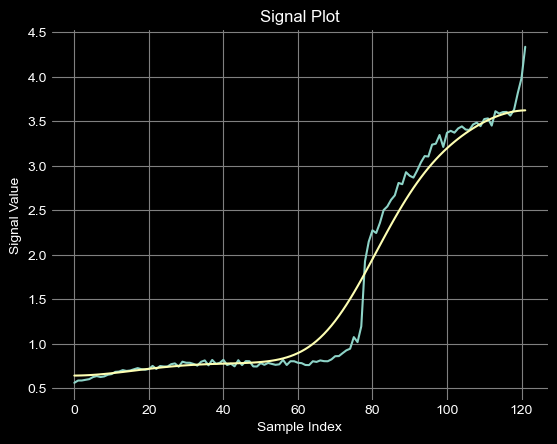

In [54]:
import matplotlib.pyplot as plt

# Set the style to dark background
plt.style.use('dark_background')

# Plot the signal with green color and grid
plt.plot(signal)
plt.plot(signal_smothed)
plt.grid(True, color='gray')  # Add grid with gray color

# Set title and axis labels with white text
plt.title('Signal Plot', color='white')
plt.xlabel('Sample Index', color='white')
plt.ylabel('Signal Value', color='white')

# Show the plot
plt.show()
